# Plan
## This notebook
1.   Walk through the boilerplate code
2.   You write your first 1D GAN

## Rest of the seminar
1. Review a GAN to generate faces
2. Adapt the 1D GAN for 5D conditional BaBar DIRC generation
3. Make it into a Wassershtein GAN

__@this notebook__ will guide you through a very simple case of generative adversarial networks.

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Like.. veeery simple. Generative adversarial network learn to sample distributions. And here we will solve the easiest imaginable task -  learning to sample a 1D normal data distribution.

Unlike many other notebooks, this one features a lot of useful visualizations that will help you both get acquainted with the behavior of two networks and debug common errors without having to wait hours of GPU time.

Inherited from https://github.com/yandexdataschool/Practical_DL/blob/spring2019/week08_adversarial/simple_1d_gan_pytorch.ipynb

# Task 1 (difficulty: the easiest GAN we managed to invent)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from scipy.stats import ks_2samp
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
LATENT_DIM = 4
def sample_noise(batch_size, dim=LATENT_DIM):
    """Returns uniform noise of shape [batch_size, LATENT_DIM] in range [0, 1]"""
    return torch.rand(batch_size, dim)

def sample_real_data(batch_size):
    """
    Returns a sample of the target distribution -
    Gaussian(mu=5, std=1.5) of shape [batch_size, 1]
    """
    #return 
    #print(torch.rand(batch_size, 1, device="cuda") * 1.5 + 5)
    #print("\n\n\n\n")
    normal = torch.distributions.Normal(loc=5, scale=1.5)
    return normal.sample((batch_size, 1))

In [3]:
# Generator converts noise into 1D data
gen = nn.Sequential(nn.Linear(LATENT_DIM, 16), nn.ELU(),
                    nn.Linear(16, 16), nn.ELU(),
                    nn.Linear(16, 1))
gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)

# Discriminator converts data into a single number, whose
# softmax is the probability of the example being real.
# It is deliberately made stronger than generator to make sure disc
# is slightly "ahead in the game".
disc = nn.Sequential(nn.Linear(1, 32), nn.ELU(),
                     nn.Linear(32, 32), nn.ELU(),
                     nn.Linear(32, 1))
disc_opt = torch.optim.SGD(disc.parameters(), lr=1e-3)

OK, now that we have our model defined, we need our loss functions. Historically the first loss used in GANs is the cross-entropy that we already used so many times:
$$\mathscr{L}^{\text{discr}} =
-\mathbb{E}\log\left[P(\text{real is real})\right]
-\mathbb{E}\log\left[P(\text{fake is fake})\right]
=
-\mathbb{E}\left[\log D(x_\text{real})\right]
-\mathbb{E}\left[\log (1 - D(x_\text{fake}))\right] 
$$

The generator loss presents a choice. We can either maximize the likelihood that generated examples are labeled as real, or minimize the likelihood that they are labeled false.

$$\mathscr{L}^{\text{gen}} =
-\mathbb{E}\log\left[P(\text{fake is real})\right] =
-\mathbb{E}\left[\log (D(x_\text{fake}))\right]$$

OR

$$\mathscr{L}^{\text{gen}} =
\mathbb{E}\log\left[P(\text{fake is fake})\right] =
\mathbb{E}\left[\log (1 - D(x_\text{fake}))\right]$$

**Question to you.** Which way do think is better?

Note that here $D(x)$ is the probability the discriminator assigns to $x$ to be from the real dataset, don't forget to apply sigmoid to the NN's output: $D(x) = \sigma(\text{discriminator}(x))$. Try implementing these loss functions below. You should use the `logsigmoid` as a stable realization of $log\left[\sigma(x)\right]$. Note that $1 - \sigma(x) = \sigma(-x)$.

In [4]:
  def train_disc(batch_size, dim=LATENT_DIM):
    """
    Trains the discriminator for one step. Please note
    this is not a pure function, it captutes the majority of variables
    from the context.
    """
    
    # compute logp(real | x)
    real_data = sample_real_data(batch_size)
    logp_real_is_real = F.logsigmoid(disc(real_data)).mean()
    
    noise = sample_noise(batch_size, dim=dim)

    gen_data = gen(noise)
    logp_gen_is_fake = F.logsigmoid(-disc(gen_data)).mean()
    # Note that sigmoid from the discrimiantor output is
    # the probability that the example is real. The definition of sigmoid
    # https://de.wikipedia.org/wiki/Sigmoidfunktion
    # is your friend here for an elegant expression.
    
    # You want the discriminator to maximize the probabilities
    # of real examples being labeled real and fake examples being labeled fake
    disc_loss = -(logp_real_is_real + logp_gen_is_fake)

    # SGD step. We zero_grad first to clear any gradients left from generator training
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()

In [5]:
def train_gen(batch_size, dim=LATENT_DIM):
    """Trains generator for one step"""
        
    # compute logp(real | G(z)).
    noise = sample_noise(batch_size, dim=dim)

    gen_data = gen(noise)
    
    logp_gen_is_real = F.logsigmoid(disc(gen_data)).sum()
    
    # The generator training wants to maximize the probability that
    # the generated examples are labeled real by the descriminator
    gen_loss = -logp_gen_is_real
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

In [6]:
def train_n_test(dim=LATENT_DIM):
    DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
    TRAIN_BATCH_SIZE = 128
    VALIDATION_BATCH_SIZE = 2048
    VALIDATION_INTERVAL = 256
    HIST_BINS=30
    DATA_HIST_RANGE=[0, 10]

    data_linspace_np = np.linspace(0, 10, num=256, dtype=np.float32)
    data_linspace_torch = torch.from_numpy(data_linspace_np)[:, None]

    for i in range(100000):
        for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
            train_disc(TRAIN_BATCH_SIZE, dim=dim)

        train_gen(TRAIN_BATCH_SIZE, dim=dim)

            if i % VALIDATION_INTERVAL == 0:
                clear_output(True)
                validation_noise = sample_noise(VALIDATION_BATCH_SIZE, dim=dim)
                validation_data = sample_real_data(VALIDATION_BATCH_SIZE)
                validation_generated = gen(validation_noise)

                validation_generated_np = validation_generated.data.cpu().numpy()
                validation_data_np = validation_data.data.cpu().numpy()
                fig, (ax_data, ax_losses) = plt.subplots(ncols=2, figsize=[14, 6])
                ax_data.set_title("Data distributions")
                ax_data_plots = []
                ax_data_plots.append(ax_data.hist(validation_generated_np, range=DATA_HIST_RANGE,
                                      alpha=0.5, density=True, label='Generated', bins=HIST_BINS)[2][0])
                ax_data_plots.append(ax_data.hist(validation_data_np, range=DATA_HIST_RANGE,
                                      alpha=0.5, density=True, label='Real', bins=HIST_BINS)[2][0])
                ax_data.set_xlabel("x")
                ax_data.set_ylabel("data & generated distributions")
                disc_preal_np = torch.sigmoid(disc(data_linspace_torch)).data.cpu().numpy()
                ax_disc = ax_data.twinx()
                ax_data_plots.extend(ax_disc.plot(data_linspace_np, disc_preal_np, label="discriminator's P(x is real)"))
                ax_disc.set_ylabel("discriminator's P(x is real)")
                ax_data.legend(ax_data_plots, [o.get_label() for o in ax_data_plots], loc="best")

                ax_losses.set_title("Discriminator readout distribution")
                ax_losses.hist(torch.sigmoid(disc(validation_generated)).data.cpu().numpy(),
                          range=[0, 1], alpha=0.5, label='D(G(z)) //  generated data', bins=HIST_BINS, density=True)
                ax_losses.hist(torch.sigmoid(disc(validation_data)).data.cpu().numpy(),
                          range=[0, 1], alpha=0.5, label='D(x) // real data', bins=HIST_BINS, density=True)
                ax_losses.legend()
                ax_losses.set_xlabel("Discriminator output")
                fig.suptitle("Iteration {}, Kolmogorov-Smirnov statistic {}".format(
                      i, ks_2samp(validation_generated_np.ravel(),
                                  validation_data_np.ravel())))
            plt.show()

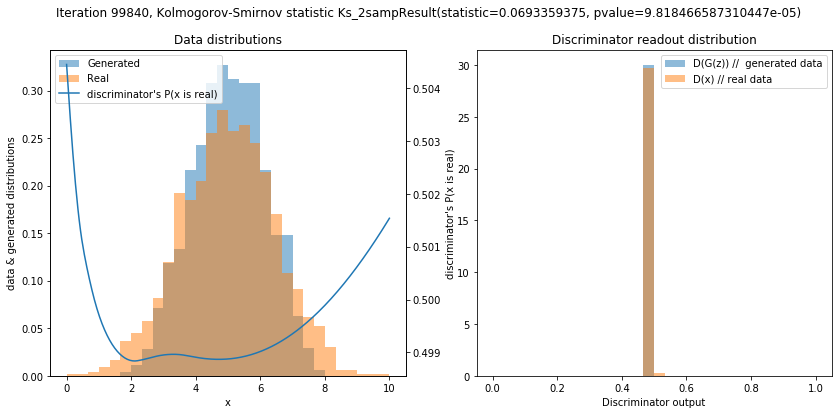

In [7]:
train_n_test()

Question to you. Do you think adding dropout will improve the model?

__What to expect:__
* __left:__ two distributions will start differently, but generator distribution should match real data _almost_ everywhere. The curve represents discriminator's opinion on all possible values of x. It should slowly get closer to 0.5 over areas where real data is dense.
* __right:__ this chart shows how frequently does discriminator assign given probability to samples from real and generated data samples (shown in different colors). First several iterations will vary, but eventually they will both have nearly all probability mass around 0.5 as generator becomes better at it's job.
 * If instead it converges to two delta-functions around 0(gen) and 1(real) each, your discriminator has won. _Check generator loss function_. As a final measure, try decreasing discriminator learning rate. This can also happen if you replace mean over batch with sum or similar.
 * If it converges to 0.5 and stays there for several iterations but generator haven't learned to generate plausible data yet, generator is winning the game. _Double-check discriminator loss function_.
 
 __Reference plots for a trained GAN__:
 ![Reference plots for a trained GAN](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-6/trained_1D_GAN.png)

# Task 1.X Bonus (diffuculty: we don't guarantee it's possible)
The GAN above transformes 4D latent space into 1D Gaussian.
Make a GAN that would transform 1D $\mathbb U[0, 1]$ space into the same 1D Gaussian.
P. S.
It is a trivila task for, say, quantile transform. But we speak GAN here.

In [49]:
gen = nn.Sequential(torch.nn.Linear(1, 4),
                    torch.nn.ELU(),
                    torch.nn.Dropout(p=0.1),
                    nn.Linear(4, 16), nn.ELU(),
                    nn.Linear(16, 32), nn.ELU(),
                    torch.nn.Dropout(p=0.5),
                    nn.Linear(32, 1))
gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)

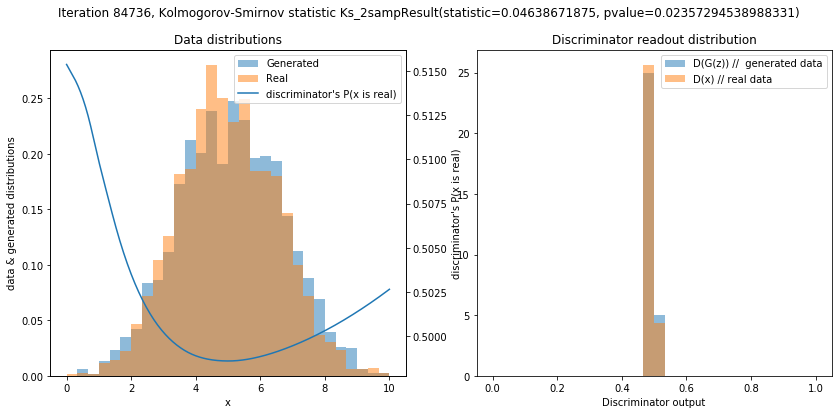

In [ ]:
train_n_test(1)

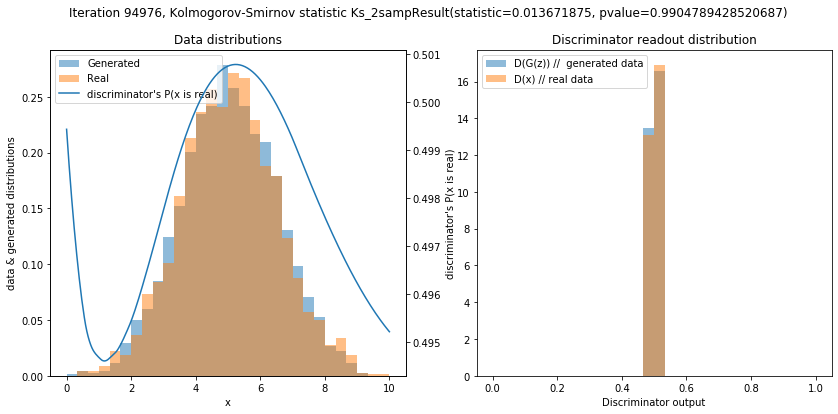

KeyboardInterrupt: 

In [46]:
train_n_test(1)

## MNIST GAN

In [ ]:
def load_minst_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - x_tain.mean()) / x_train.mean()      
    x_train = x_train.reshape(60000, 784)                 
    return (x_train, y_train, x_test, y_test)
np.random.seed(42)
random_dim = 100

In [ ]:
class GenNet(nn.Module):
    def __init__(self, D_in, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 128 * 4 * 4)
        self.dropout_small = nn.Dropout(0.2)
        self.dropout_big = nn.Dropout(0.5)
        self.conv3_128 = nn.Conv2d(128, 64, kernel_size=3, padding=1),
        self.ups = torch.nn.Upsample(scale_factor=2),
        self.conv3_64 = nn.Conv2d(64, 32, kernel_size=3, padding=1),
        self.conv5_32 = nn.Conv2d(32, 32, kernel_size=5, padding=2),
        self.linear2 = torch.nn.Linear(32 * 8 * 8, 3 * 28 * 28)
        

    def forward(self, x):
        x = self.dropout_small(F.relu(self.linear1(x))) 
        x = x.view(-1, 128, -1) # 128 x 4 x 4
        x = self.dropout_small(F.relu(self.conv3_128(x))) # 64 x 4 x 4
        x = self.ups(x) # 64 x 8 x 8
        x = self.dropout_small(F.relu(self.conv3_64(x))) # 32 x 8 x 8
        x = self.dropout_small(F.relu(self.conv5_32(x))) # 32 x 8 x 8
        x = self.dropout_big(F.relu(self.linear2(x)))
        return x.view(-1, 3, 28, 28)

    
class DiscNet(nn.Module):
    def __init__(self):
        super(DiscNet, self).__init__()
        self.linear1 = nn.Linear(3 * 28 * 28, 3 * 32 * 32),
        self.dropout_small = nn.Dropout(0.2)
        self.dropout_big = nn.Dropout(0.5)
        self.conv3_3 = nn.Conv2d(3, 8, kernel_size=3, padding=1), 
        self.max_pool = nn.MaxPool2d(2),
        self.conv5_8 = nn.Conv2d(8, 16, kernel_size=5, padding=2), 
        self.conv3_16 = nn.Conv2d(16, 32, kernel_size=3, padding=1), 
        self.conv3_32 = nn.Conv2d(32, 64, kernel_size=3, padding=1),       
        self.linear2 = nn.Linear(64 * 8 * 8, 8 * 8)
        self.linear3 = nn.Linear(8 * 8, 1)

    def forward(self, x):
        x = x.view(-1, 3 * 28 * 28)
        x = F.elu(self.linear1(x))
        x = x.view(-1, 3 * 32 * 32)
        x = self.dropout_small(F.relu(self.conv3_3(x))) # 8 x 32 x 32
        x = self.max_pool(x) # 8 x 16 x 16
        x = self.dropout_small(F.relu(self.conv5_8(x))) # 16 x 16 x 16
        x = self.dropout_small(F.relu(self.conv3_16(x))) # 32 x 16 x 16
        x = self.max_pool(x) # 32 x 8 x 8
        x = self.dropout_small(F.relu(self.conv3_32(x))) # 64 x 8 x 8 
        x = self.dropout_big(F.elu(self.linear2(x)))
        x = self.dropout_big(F.sigmoid(self.linear3(x)))
        return x
    


In [ ]:
  def train_disc(batch_size, dim=LATENT_DIM):
    """
    Trains the discriminator for one step. Please note
    this is not a pure function, it captutes the majority of variables
    from the context.
    """
    
    # compute logp(real | x)
    real_data = sample_real_data(batch_size)
    logp_real_is_real = F.logsigmoid(disc(real_data)).mean()
    
    noise = sample_noise(batch_size, dim=dim)

    gen_data = gen(noise)
    logp_gen_is_fake = F.logsigmoid(-disc(gen_data)).mean()
    # Note that sigmoid from the discrimiantor output is
    # the probability that the example is real. The definition of sigmoid
    # https://de.wikipedia.org/wiki/Sigmoidfunktion
    # is your friend here for an elegant expression.
    
    # You want the discriminator to maximize the probabilities
    # of real examples being labeled real and fake examples being labeled fake
    disc_loss = -(logp_real_is_real + logp_gen_is_fake)

    # SGD step. We zero_grad first to clear any gradients left from generator training
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()


def train_gen(batch_size, dim=LATENT_DIM):
    """Trains generator for one step"""
        
    # compute logp(real | G(z)).
    noise = sample_noise(batch_size, dim=dim)

    gen_data = gen(noise)
    
    logp_gen_is_real = F.logsigmoid(disc(gen_data)).sum()
    
    # The generator training wants to maximize the probability that
    # the generated examples are labeled real by the descriminator
    gen_loss = -logp_gen_is_real
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()